In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import cv2 as cv
import os
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score

import torchvision
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# from tqdm import tqdm # See progress in terminal
# from torch.utils.tensorboard import SummaryWriter 

from data import download_all_data, preprocess_gt, mirror_transform, elastic_transform, ImageDataset
from network import Unet
from functions import weighted_map, input_size_compute, IoU, Pixel_error, evaluation_metrics

from time import time

CUR_DIR = os.path.abspath('')

# Dataset


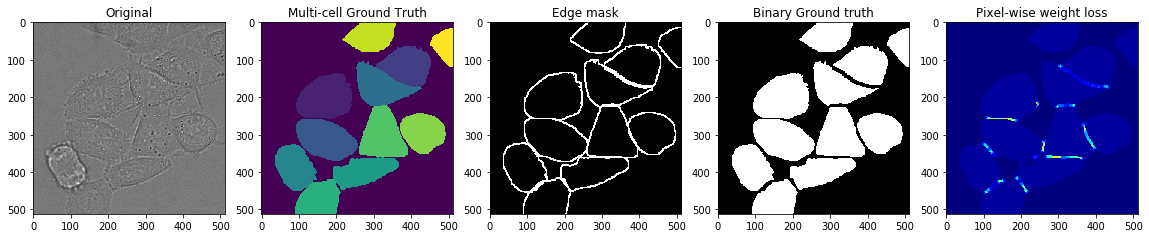

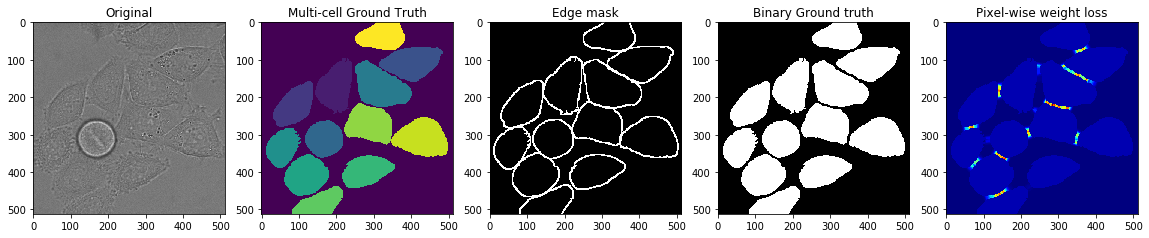

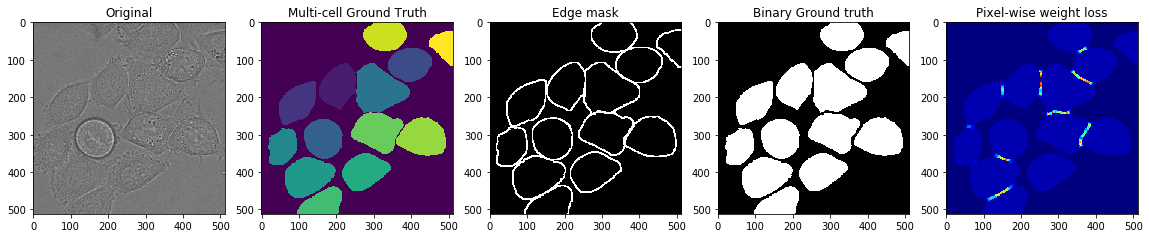

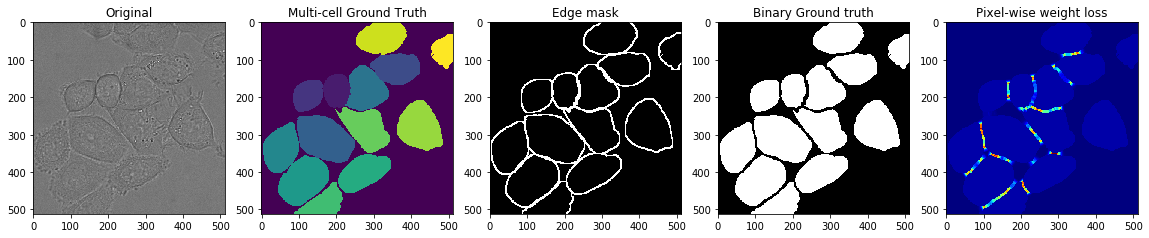

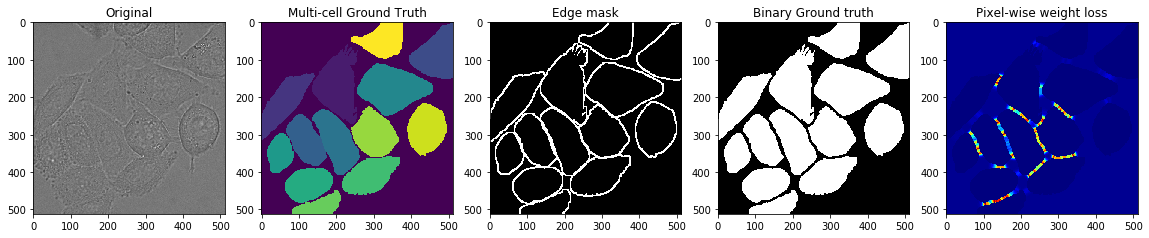

In [5]:
# Download data
download_all_data()

# Specify which dataset to analyse
# DATASET = 'PhC-C2DH-U373'
# DATASET = 'ISBI2012'
DATASET = 'DIC-C2DH-HeLa'

target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
training_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01")
target = os.listdir(target_path)
# for i in range(len(target)):
for i in range(5):
    # load images
    img_training = cv.imread(os.path.join(training_path, f"t{target[i][7:]}"))
    img_gt = cv.imread(os.path.join(target_path, target[i]), -1)
    
    # image morphology, for edge detection (ONLY FOR DIC-C2DH-HeLa, since cells intersect)
    gt, mask_global = preprocess_gt(img_gt)
    if DATASET != "DIC-C2DH-HeLa":
        gt = img_gt
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.imshow(img_training)
    plt.title("Original")
    plt.subplot(1,5,2)
    plt.imshow(img_gt)
    plt.title('Multi-cell Ground Truth')
    plt.subplot(1,5,3)
    plt.title('Edge mask')
    plt.imshow(mask_global > 0, cmap='gray')  # binary of cell edges
    plt.subplot(1,5,4)

    _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
    plt.imshow(torch.from_numpy(gt_bin), cmap='gray')
    plt.title('Binary Ground truth')
    
    # Calculating loss for ground truth
    loss_img = weighted_map(torch.from_numpy(gt_bin.reshape((1,1,512,512))) / 255, 1).numpy().reshape((512,512))
    plt.subplot(1,5,5)
    plt.imshow(loss_img, cmap='jet')
    plt.title("Pixel-wise weight loss")
    plt.tight_layout()
    plt.show()

# Data Augmentation

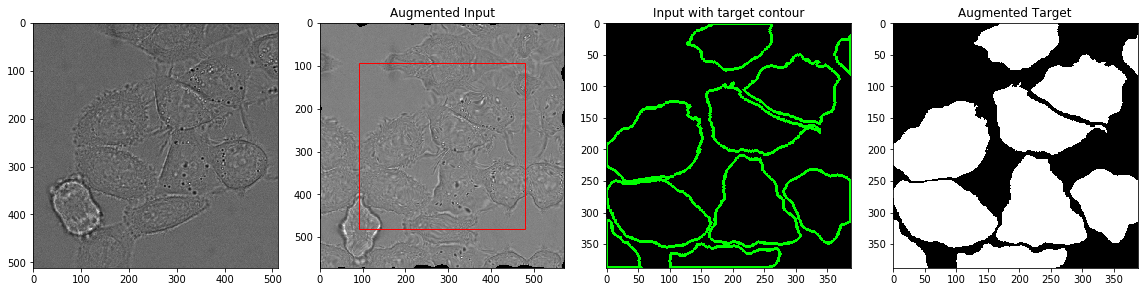

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, alpha=3, sigma=10, transform=True):
        self.root_dir = root_dir
        self.alpha = alpha
        self.sigma = sigma

        self.image = []
        self.target = []
        self.transform = transform

        n = len(os.listdir(root_dir)) // 3
        for i in range(1, n+1):
            image_folder = os.path.join(root_dir, f"0{i}")
            target_folder = os.path.join(os.path.join(root_dir, f"0{i}_GT", "SEG"))
            image_names = [filename.replace('man_seg', 't') for filename in os.listdir(target_folder)]
            self.image.extend(cv.imread(os.path.join(image_folder, image_name),-1) for image_name in image_names)
            for filename in os.listdir(target_folder):
                img = cv.imread(os.path.join(target_folder, filename), -1)
                gt, _ = preprocess_gt(img)
                _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
                self.target.append(gt_bin)


    def __len__(self):
        if self.transform:
            return len(self.image)
        return 4*len(self.image)  # hardcoded

    def __getitem__(self, idx):
        if self.transform:
            # Get images
            image = self.image[idx]
            target = self.target[idx]
            # Random crop
            x = np.random.randint(0, 512-388)
            y = np.random.randint(0, 512-388)
            # Mirror border
            image = mirror_transform(image[x:x+388, y:y+388])
            target = mirror_transform(target[x:x+388, y:y+388])
            # Perform same elastic transformation 
            inp, gt = elastic_transform((image, target), alpha=self.alpha, sigma=self.sigma)
        else:
            # TODO: hardcoded // 512 -> input image size from dataset; 388 -> network's output map
            image_size = self.image[idx].shape[-1]
            target_size = self.target[idx].shape[-1]
            i = idx // 4
            x = (image_size-target_size)*(idx % 2)
            y = (image_size-target_size)*((idx - 4 * i) // 2)
            inp = mirror_transform(self.image[i][x:x+target_size, y:y+target_size])
            gt = mirror_transform(self.target[i][x:x+target_size, y:y+target_size])
        
        gt = gt[92:388+92, 92:388+92]  # crop gt
        _, gt = cv.threshold(gt, 127, 255, cv.THRESH_BINARY)
        gt = gt / 255  # normalize to [0 1]
        inp = (inp - np.min(inp))/np.ptp(inp)  # normalize to [0 1]
        return transforms.ToTensor()(inp.astype('float32')), \
               transforms.ToTensor()(gt).long()

# init ImageDataset
root_dir = os.path.join(CUR_DIR, "data", "DIC-C2DH-HeLa-training")
transformed_dataset = ImageDataset(root_dir, alpha=250, sigma=10)
val_per = 0.3
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [int(len(transformed_dataset) * (1-val_per)), int(len(transformed_dataset) * val_per)+1])

# visualise augmentation
for i in range(1):
    img, gt = transformed_dataset[i]
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(141)
    ax1 = fig.add_subplot(142)
    ax2 = fig.add_subplot(143)
    ax3 = fig.add_subplot(144)
    ax0.imshow(transformed_dataset.image[i], cmap='gray')
    ax1.imshow(img.reshape(img.shape[1:]), cmap='gray')
    rect = patches.Rectangle((92,92),388,388,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax1.add_patch(rect)
    ax1.set_title("Augmented Input")
    gt = gt[0,:,:].reshape((1,388,388))
    gt = gt.reshape(gt.shape[1:]).numpy().astype(np.uint8)
    contours, hierarchy = cv.findContours(gt, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    image = cv.cvtColor(img.reshape(img.shape[1:])[92:92+388,92:92+388].numpy().astype(np.uint8),cv.COLOR_GRAY2RGB)
    cv.drawContours(image, contours, -1, (0, 255, 0), 3)
    ax2.imshow(image)
    ax2.set_title("Input with target contour")

    ax3.imshow(gt, cmap='gray')
    ax3.set_title("Augmented Target")
    fig.tight_layout()
    plt.show()

In [7]:
root_dir = os.path.join(CUR_DIR, "data", "DIC-C2DH-HeLa-training")
transformed_dataset = ImageDataset(root_dir, alpha=250, sigma=10)
val_per = 0.3
batch_size = 4
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [int(len(transformed_dataset) * (1-val_per)), int(len(transformed_dataset) * val_per)+1])

# init DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

# Testing

In [8]:
def mirror_transform_test(image, input_size):
    ''' Fills the difference in size between the original image or patch to the input_size of the newtork mirroring the original image outwards.
        We shall use this on the test dataset only.
        
        Inputs:
            - image: original image from the dataset. Torch tensor of shape [(1), (1), original_size, original_size].
            - input_size: input size for the network, precomputed by the functions.input_size_compute method.

        Output: 
            - new_image: mirrored image. Torch tensor of shape [1, 1, input_size, input_size].
    '''
    image = image.reshape([image.shape[-1], image.shape[-1]]).numpy()
    n = len(image)
    pad = (input_size - n) // 2
    new_image = np.zeros((input_size, input_size))
    new_image[pad:pad+n,    pad:pad+n] = image
    new_image[:pad,         pad:pad+n] = image[pad:0:-1, 0:n]  # left side
    new_image[:pad,         :pad     ] = new_image[0:pad, pad+pad:pad:-1]  # top left
    new_image[:pad,         pad+n:   ] = new_image[0:pad, n+pad-1:n-1:-1]  # bot left
    new_image[n+pad:,       pad:pad+n] = image[n:n-pad-1:-1, 0:n]  # right side
    new_image[n+pad:,       :pad     ] = new_image[n+pad:, pad+pad:pad:-1]  # top right
    new_image[n+pad:,       n+pad:   ] = new_image[n+pad:, n+pad-1:n-1:-1]  # bot right
    new_image[pad:n+pad,    :pad     ] = image[:, pad:0:-1] # top side
    new_image[pad:n+pad,    n+pad:   ] = image[:, n-1:n-1-pad:-1]  # bot side
    new_image = torch.from_numpy(new_image).reshape([1, 1, input_size, input_size])

    return new_image

class ImageDataset_test(Dataset):
    def __init__(self, root_dir, alpha=3, sigma=10, transform=True):
        self.root_dir = root_dir
        self.alpha = alpha
        self.sigma = sigma

        self.image = []
        self.target = []
        self.transform = transform

        n = len(os.listdir(root_dir)) // 3
        for i in range(1, n+1):
            image_folder = os.path.join(root_dir, f"0{i}")
            target_folder = os.path.join(os.path.join(root_dir, f"0{i}_GT", "SEG"))
            image_names = [filename.replace('man_seg', 't') for filename in os.listdir(target_folder)]
            self.image.extend(cv.imread(os.path.join(image_folder, image_name),-1) for image_name in image_names)
            for filename in os.listdir(target_folder):
                img = cv.imread(os.path.join(target_folder, filename), -1)
                gt, _ = preprocess_gt(img)
                _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
                self.target.append(gt_bin)


    def __len__(self):
        if self.transform:
            return len(self.image)
        return 4*len(self.image)  # hardcoded

    def __getitem__(self, idx):
        if self.transform:
            # Get images
            image = self.image[idx]
            target = self.target[idx]
            # Random crop
            x = np.random.randint(0, 512-388)
            y = np.random.randint(0, 512-388)
            # Mirror border
            image = mirror_transform(image[x:x+388, y:y+388])
            target = mirror_transform(target[x:x+388, y:y+388])
            # Perform same elastic transformation 
            inp, gt = elastic_transform((image, target), alpha=self.alpha, sigma=self.sigma)
        else:
            # TODO: hardcoded // 512 -> input image size from dataset; 388 -> network's output map
            # image_size = self.image[idx].shape[-1]
            # target_size = self.target[idx].shape[-1]
            i = idx // 4
            # x = (image_size-target_size)*(idx % 2)
            # y = (image_size-target_size)*((idx - 4 * i) // 2)
            # inp = mirror_transform(self.image[i][x:x+target_size, y:y+target_size])
            # gt = mirror_transform(self.target[i][x:x+target_size, y:y+target_size])
            inp = self.image[i]
            gt = self.target[i]
        
        # gt = gt[92:388+92, 92:388+92]  # crop gt
        _, gt = cv.threshold(gt, 127, 255, cv.THRESH_BINARY)
        gt = gt / 255  # normalize to [0 1]
        inp = (inp - np.min(inp))/np.ptp(inp)  # normalize to [0 1]

        return transforms.ToTensor()(inp.astype('float32')), \
               transforms.ToTensor()(gt).long()

In [9]:
# init ImageDataset
root_dir = os.path.join(CUR_DIR, "data", "DIC-C2DH-HeLa-training")
clean_dataset = ImageDataset_test(root_dir, transform=False)

val_per = 0.3
batch_size = 4 

train_size = int(len(transformed_dataset)*(1-val_per))

test_clean_set = torch.utils.data.Subset(clean_dataset, range(train_size, len(clean_dataset)))  # TODO: 4 hardcoded

test_clean_loader = DataLoader(test_clean_set, batch_size=1, shuffle=False)

In [10]:
for batch in test_clean_loader:
    image, label = batch

In [11]:
print(image.shape, label.shape)

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])


In [12]:
original_size, input_size, output_size = input_size_compute(image)
input_image = mirror_transform_test(image, input_size).float()

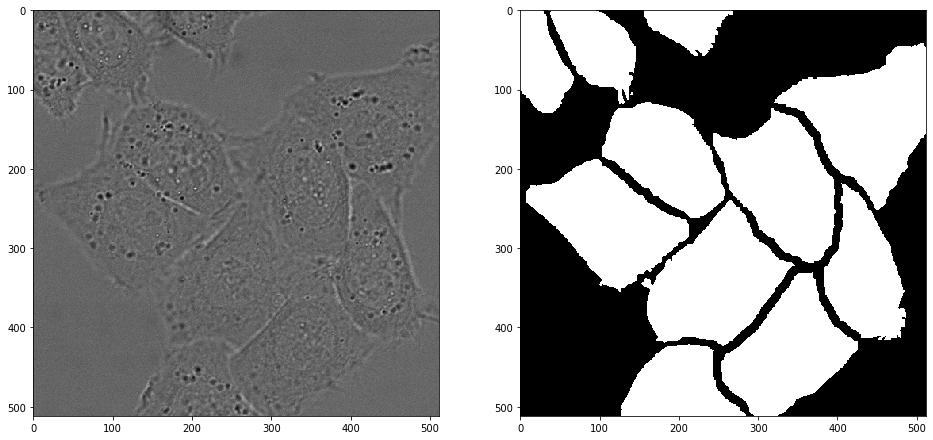

In [13]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)

    ax0.imshow(image[0, 0, :, :], cmap='gray')
    ax1.imshow(label[0, 0, :, :], cmap='gray')

In [14]:
# unet = Unet()
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

model_dir = os.path.join(CUR_DIR, 'unet_weight_save_5000.pth')
unet = Unet().to(device)
unet.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))

Running on the CPU


<All keys matched successfully>

In [15]:
start = time()
preds = unet(input_image.to(device)) # Should be trained model
print('time =', time() - start)
preds.shape

time = 7.709653854370117


torch.Size([1, 2, 516, 516])

In [16]:
# Test for time comparison

# input_image2 = input_image[:, :, :572, :572]

# start2 = time()
# preds2 = unet(input_image2.to(device)) # Should be trained model
# end2 = time() - start2
# print(end2)
# preds2.shape

In [17]:
pad = int((output_size - original_size) / 2)
preds_back = preds[:, :, pad:preds.shape[-1]-pad, pad:preds.shape[-1]-pad].argmin(dim=1)
preds_fore = preds[:, :, pad:preds.shape[-1]-pad, pad:preds.shape[-1]-pad].argmax(dim=1)

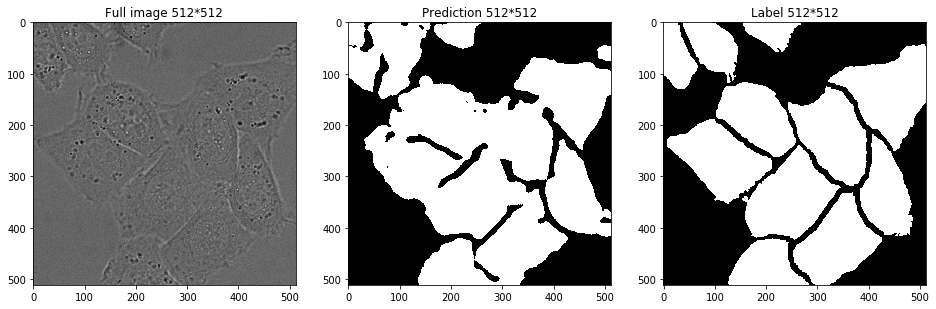

In [18]:
for i in range(1):
    fig = plt.figure(figsize=(16,9))
    ax0 = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)

    ax0.imshow(image[0, 0, :, :], cmap='gray')
    ax1.imshow(preds_fore[0, :, :], cmap='gray')
    ax2.imshow(label[0, 0, :, :], cmap='gray')

    ax0.set_title('Full image 512*512')
    ax1.set_title('Prediction 512*512')
    ax2.set_title('Label 512*512')

In [19]:
pred_back_np = preds_back.numpy()
pred_back_np.shape

(1, 512, 512)

In [23]:
preds_back_np = preds_back.numpy()
preds_fore_np = preds_fore.numpy()
label_back_np = np.ones(preds_back.shape) - label.reshape_as(preds_back).numpy()
label_fore_np = label.reshape_as(preds_fore).numpy()

a = np.sum(preds_back_np[label_back_np==1]==1) + np.sum(preds_fore_np[label_fore_np==1]==1) # tn + tp
b = np.sum(preds_back_np[label_back_np==0]==1) + np.sum(preds_fore_np[label_fore_np==0]==1) # fn + fp

print(a, b, a + b, preds_back_np.size)

den = scipy.special.comb(preds_fore_np.size, 2)

print(den)

RI = (a + b) / den
RE = 1 - RI

print(RI, RE)

234960 27184 262144 262144
34359607296.0
7.629423635191479e-06 0.9999923705763648


In [30]:
RI = adjusted_rand_score(preds_fore_np.reshape([preds_fore_np.size]), label_fore_np.reshape([label_fore_np.size]))
RE = 1. - RI

In [31]:
print(RE, RI)

0.3718660304456909 0.6281339695543091
